In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
# Read csv file into dataframe
df = pd.read_csv('CarMarket_Data.csv')

df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [4]:
df.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

In [5]:
df = df.dropna(how='any',axis=0)

In [6]:
df.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

In [7]:
df.describe()

,year,condition,odometer,mmr,sellingprice
count,472325.000000,472325.000000,472325.000000,472325.000000,472325.000000
mean,2010.210980,30.774177,66701.732040,13837.058964,13690.512058
std,3.822151,13.286866,51939.586894,9532.229273,9613.033738
min,1990.000000,1.000000,1.000000,25.000000,1.000000
25%,2008.000000,24.000000,28137.000000,7425.000000,7200.000000
50%,2012.000000,35.000000,51085.000000,12300.000000,12200.000000
75%,2013.000000,41.000000,96590.000000,18300.000000,18200.000000
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000


In [8]:
# Additional features and datetime conversions
df['vehicle_age'] = 2025 - df['year']  

df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', utc=True) 

df['sale_month'] = df['saledate'].dt.month 

C:\Users\Garrett\AppData\Local\Temp\ipykernel_2640\2820975512.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', utc=True)


In [9]:
# Analysis on categorical variables unique classes
cat_cols = df.select_dtypes(include=['object']).columns

# counting unique values in each categorical column
cat_counts = {col: df[col].nunique() for col in cat_cols}
cat_counts_df = pd.DataFrame.from_dict(cat_counts, orient='index', columns=['Unique_Classes'])
cat_counts_df.sort_values(by='Unique_Classes', ascending=False)

,Unique_Classes
vin,465768
seller,11923
trim,1494
model,768
body,85
make,53
state,34
color,20
interior,17
transmission,2


In [10]:
# Drop unnecessary features
df = df.drop(columns=['vin', 'seller'])

In [11]:
# Random Forest Regressor Pipeline using StandardScaler, OneHotEncoder, and GridSearchCV

# target variable y and predictors X
target = 'sellingprice'
predictors = ['year', 'condition', 'odometer', 'mmr', 'vehicle_age', 'sale_month',
            'make', 'model', 'trim', 'body', 'transmission', 'color', 'interior', 'state']

X = df[predictors]
y = df[target]

# separate columns by dtype
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# data transformers (preprocessing)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# preprocessor ColumnTransformer for both dtypes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Pipeline for transformers and Random Forest Regressor model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# parameter grid for GridSearchCV
param_grid = {
    'regressor__max_depth': [10, 15, 20],
    'regressor__min_samples_split': [2, 3],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__n_estimators': [200]
}

# train-test-split 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GridSearchCV with 3 folds, verbose = '3' output setting, and using negative mean absolute error scoring
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=1, verbose=3, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# predict and evaluate with the best model parameters determined by GridSearchCV
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# print best parameters and model evaluation results
print("Best Parameters:", grid_search.best_params_)
print(f"Mean Absolute Error (MAE):  {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R^2:  {r2:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=200;, score=-4574.028 total time= 2.3min
[CV 2/3] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=200;, score=-4496.120 total time= 2.4min
[CV 3/3] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=200;, score=-4462.787 total time= 2.4min
[CV 1/3] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=3, regressor__n_estimators=200;, score=-4562.359 total time= 2.7min
[CV 2/3] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=3, regressor__n_estimators=

C:\Users\Garrett\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The parameter max_features setting for 'log2' was much faster computationally than 'sqrt' because it allows the model to require less work with less features per tree, while still maintaining an adequate degree of randomness. Did 'sqrt' manage to perform better despite having a higher computational cost?

Yes! \
At least when utilizing a max depth of 20, minimum of 1 samples leaf and 3 minimum samples split with 200 estimators and this dataset. 

C:\Users\Garrett\AppData\Local\Temp\ipykernel_2640\3023401614.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


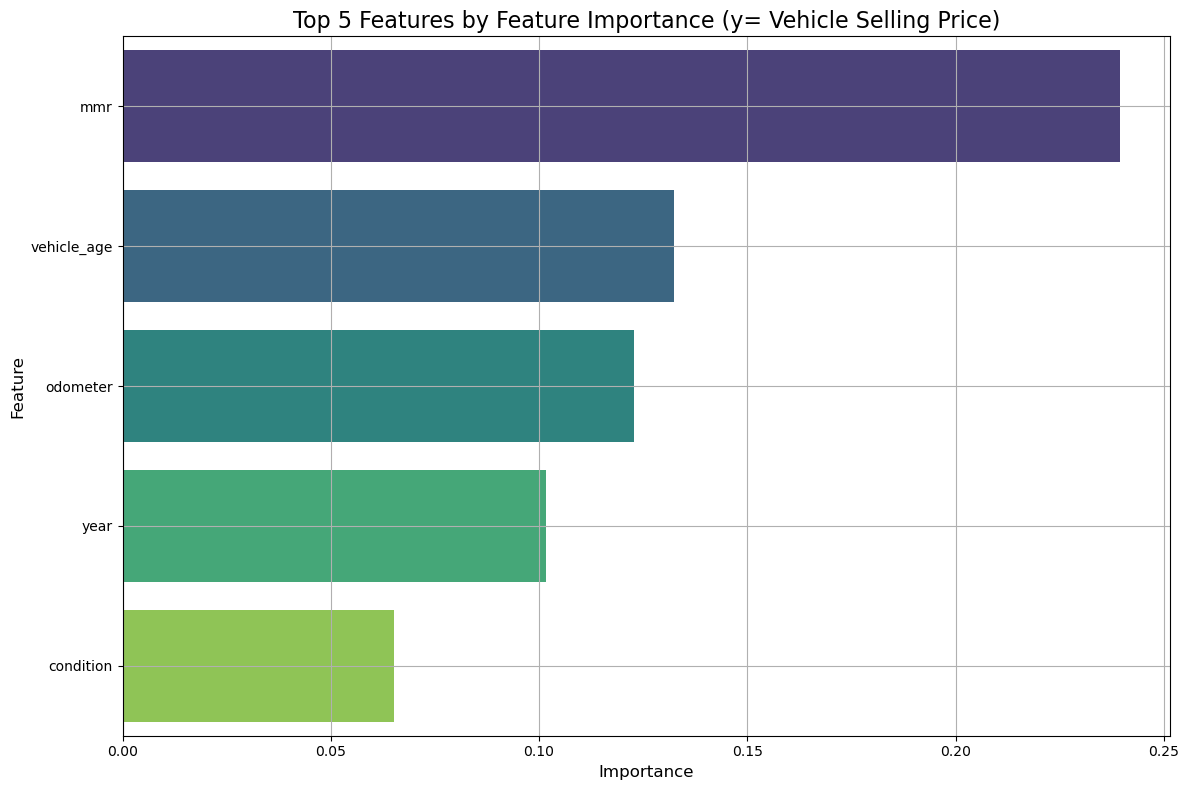

In [20]:
# Feature importance analysis with seaborn barplot

# extract features from best RFRegressor model and use feature_importances_ to save this data to a dataframe and plot with seaborn
feature_names = (
    numeric_cols + 
    list(best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))
)

importances = best_model.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# plot with seaborn barplot
plt.figure(figsize=(12, 8))

sns.barplot(
    data=feature_importance_df.head(5),  
    x='importance', 
    y='feature', 
    palette='viridis'
)

plt.title('Top 5 Features by Feature Importance (y= Vehicle Selling Price)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

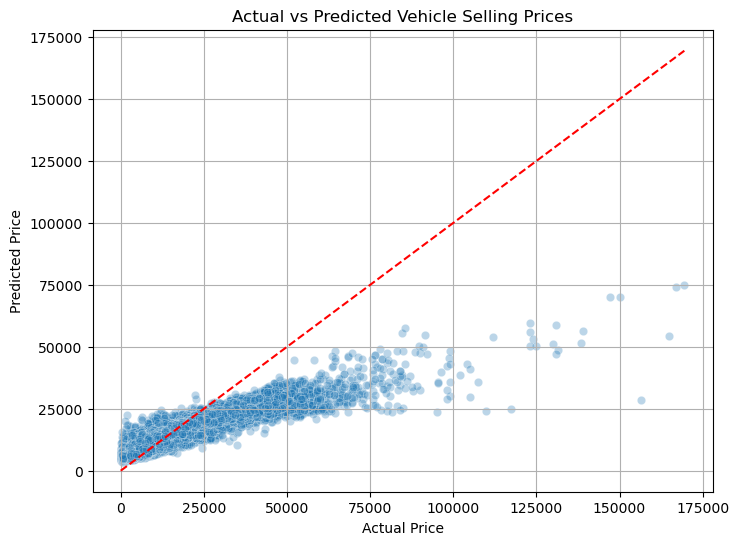

In [22]:
# Actual vs predicted selling prices seaborn scatterplot
plt.figure(figsize=(8, 6))

sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Vehicle Selling Prices')
plt.grid(True)

plt.show()

Due to the dataset selling prices having a heavily right-skewed distribution (more expensive, luxury type vehicles are more rarely sold in a used vehicle market), our model underestimated the vehicles worth overall. Now let's look into the distribution more and utilize additional methods later. 

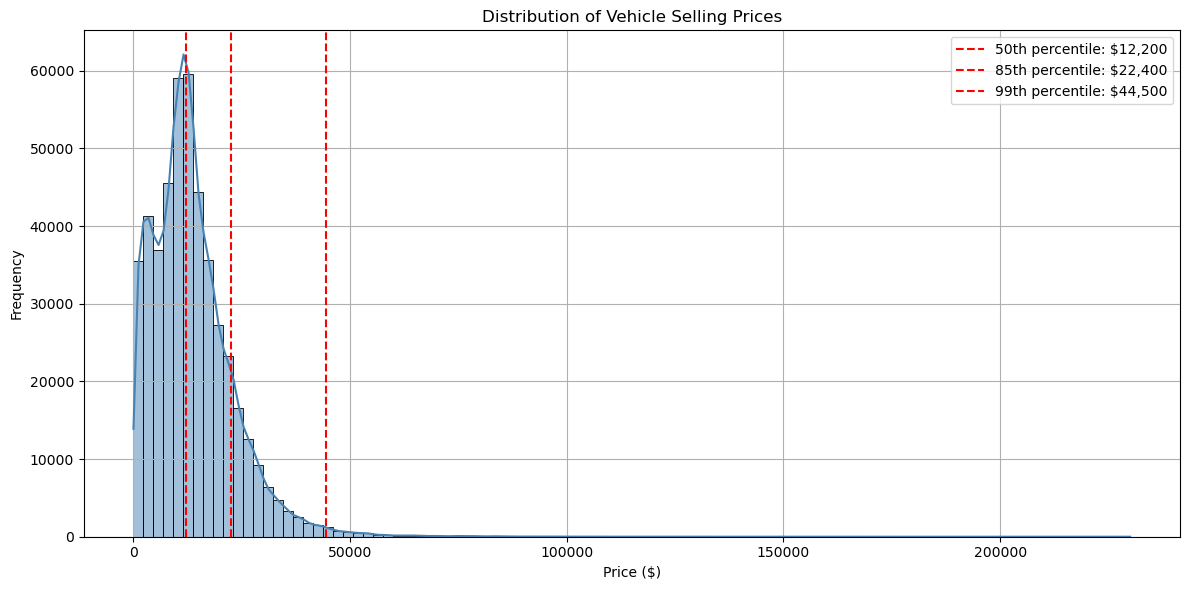

In [25]:
# Distribution of vehicle selling prices using seaborn histplot
plt.figure(figsize=(12, 6))

sns.histplot(df['sellingprice'], bins=100, kde=True, color='steelblue')

percentiles = [50, 85, 99] # these were the most logical choices for market segments I could come up with after viewing
                           # this distribution, we can see these percentiles easily by adding the code below

for p in percentiles:
    value = df['sellingprice'].quantile(p / 100)
    plt.axvline(value, color='red', linestyle='--', label=f'{p}th percentile: ${value:,.0f}') # red percentile reference lines
                                                                                              # with their respective $ value

plt.title('Distribution of Vehicle Selling Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
# Mapping percentiles to our dataframe to create a market segment column called 'tier' for our records
percent50 = df['sellingprice'].quantile(0.50)
percent85 = df['sellingprice'].quantile(0.85)
percent99 = df['sellingprice'].quantile(0.99)

# map tiers based on above percentiles
def map_price_tier(price):
    if price <= percent50:
        return 'Economy'
    elif price <= percent85:
        return 'MidRange'
    elif price <= percent99:
        return 'Premium'
    else:
        return 'Luxury'

# apply mapping to tier column based on selling price
df['tier'] = df['sellingprice'].apply(map_price_tier)

In [29]:
# Top vehicle models for each tier
top_models_by_tier = (
    df.groupby(['tier', 'model'])
    .size()
    .reset_index(name='count')
)

# sort and get the top 5 models to visualize
top5_models_per_tier = (
    top_models_by_tier
    .sort_values(['tier', 'count'], ascending=[True, False])
    .groupby('tier')
    .head(5)
)

# print
print(top5_models_per_tier)

          tier           model  count
48     Economy          Altima   8723
226    Economy           Focus   8055
281    Economy          Impala   6575
235    Economy          Fusion   5585
128    Economy           Civic   5406
734     Luxury         S-Class    308
714     Luxury        Panamera    190
635     Luxury        6 Series    177
633     Luxury        5 Series    161
638     Luxury             911    157
808   MidRange          Altima   7601
913   MidRange          Escape   7001
941   MidRange          Fusion   6452
851   MidRange           Camry   6147
946   MidRange         G Sedan   5712
1349   Premium           F-150   4928
1345   Premium        Explorer   3420
1232   Premium        3 Series   2236
1524   Premium  Silverado 1500   1697
1241   Premium        5 Series   1672


In [31]:
# Create 'discount' column based on selling price being under ('1') or above ('0') MMR value
df['discount'] = (df['sellingprice'] < df['mmr']).astype(int)

In [33]:
# Creating a Used Vehicle 'Cheat Sheet' with the new discount column and additional average offer column

# gather mean price for each model by make and year based on sales count
pricing_summary = (
    df.groupby(['year', 'make', 'model'])
    .agg({'sellingprice': 'mean', 'mmr': 'mean', 'model': 'count'})
    .rename(columns={'model': 'sales_count'})
    .reset_index()
)

# creating average offer column based on whether that model is sold under or over the MMR value on average in this data
pricing_summary['avg_offer'] = (pricing_summary['sellingprice'] < pricing_summary['mmr']).map({True: 'underpriced', False: 'overpriced'})

# 'Cheat Sheet' list will only include the top 5 models of each year
top_models_list = []

for year in range(1990, 2016):
    models_this_year = (
        pricing_summary[pricing_summary['year'] == year]
        .sort_values('sales_count', ascending=False)
        .head(5)
    )
    
    top_models_list.append(models_this_year[['year', 'make', 'model', 'avg_offer']]) # only including these columns as data

final_df = pd.concat(top_models_list, ignore_index=True)

final_df = final_df.sort_values(by=['year', 'make', 'model']).reset_index(drop=True) # mainly sorting by year

# show first 5 records
final_df.head()

,year,make,model,avg_offer
0,1990,Chevrolet,Corvette,underpriced
1,1990,Honda,Accord,underpriced
2,1990,Lexus,LS 400,underpriced
3,1990,Mazda,MX-5 Miata,underpriced
4,1990,Toyota,Camry,underpriced


In [35]:
# Save 'Cheat Sheet' data to CSV with UTF-8 encoding (otherwise receive errors)
final_df.to_csv("car_cheat_sheet.csv", index=False, encoding='utf-8-sig')

print("Data saved as: 'car_cheat_sheet.csv'")

Data saved as: 'car_cheat_sheet.csv'
